In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import gamma
import mgarch

        


# Define function to compute Black-Litterman weights based on the model inputs
def compute_black_litterman_weights(cov, pi, P, Q1, tau, omega):
    pi = pi.reshape(-1, 1)  # Ensure pi is a column vector
    # Compute the covariance matrix using Black-Litterman formula
    first_part = np.linalg.inv(np.linalg.inv(tau * cov) + np.dot(P.T, np.linalg.solve(omega, P)))
    # Compute the Black-Litterman expected returns
    second_part = np.dot(np.linalg.inv(tau * cov), pi) + np.dot(P.T, np.linalg.solve(omega, Q1))
    return np.dot(first_part, second_part).flatten()  # Flatten the matrix into a vector


def compute_optimal_weights(cov, expected_returns, G):
    
    N = cov.shape[0]  # Number of assets
    A = np.ones((1, N))  # Constraint to ensure weights sum to 1
    c = expected_returns.reshape(N, 1)  # Ensure expected returns is a column vector
    G = G.reshape(1,N)  # Ensure ESG scores is properly shaped
    h = np.asarray([25], dtype=float)  # ESG constraint threshold
    Q = cov  # Rename for clarity
    Q_inv = np.linalg.inv(Q)  # Precompute inverse of covariance matrix for efficiency

    # Compute coefficients for the optimization formula
    AQ_inv = A @ Q_inv
    GQ_inv = G @ Q_inv
    AQ_invT = AQ_inv @ A.T
    GQ_invT = GQ_inv @ G.T
    AQ_inv_c = AQ_inv @ c
    GQ_inv_c = GQ_inv @ c

    # Solve for lambda values using precomputed coefficients
    lambda_denominator = AQ_invT * GQ_invT - (GQ_inv @ A.T) ** 2
    lambda1 = (-GQ_invT * (1 - AQ_inv_c) + (GQ_inv @ A.T) * (h - GQ_inv_c)) / lambda_denominator
    lambda2 = ((GQ_inv @ A.T) * (1 - AQ_inv_c) - AQ_invT * (h - GQ_inv_c)) / lambda_denominator

    # Calculate optimized weights using the lambda values
    x = Q_inv @ (c - lambda1 * A.T - lambda2 * G.T)

    return x.flatten()

def compute_mgarch_covariance(returns, ndays=1):
    vol = mgarch.mgarch()
    vol.fit(returns)
    cov_nextday = vol.predict(ndays) 
    cov = cov_nextday['cov']
    return cov

# Load data
stocks_data = pd.read_excel('Stock Prices.xlsx').set_index('Dates')
marketcap_data = pd.read_excel('Market Caps.xlsx').set_index('Dates')
ESG_data = pd.read_excel('ESG Scores.xlsx').set_index('Dates')

# Calculating ESG deficiency scores
ESG_data = 100 - ESG_data


# Define initial parameters for the optimization
capital = 1e10  # Initial capital
days_interval = 64  # Interval for recalculating portfolio
returns, dates, dates_traded, weights = [], [], [], []

# Main loop for processing data and calculating returns
for i in range(2213, len(stocks_data), days_interval):
    # Split data into training and testing sets based on the current interval
    stocks_training = stocks_data.iloc[0:i]
    stocks_testing = stocks_data.iloc[i:i+1]
    
    # Calculate returns and covariance matrix for the training set
    rts = stocks_training.pct_change().dropna().values  
    rts_views = stocks_training.iloc[-days_interval:].pct_change().mean().values  # Views based on recent interval
    cov = compute_mgarch_covariance(rts, ndays=1)
    
    # Black-Litterman model parameters and calculations
    tau = 0.025  # Scaling factor for the uncertainty in the prior
    marketcaps = marketcap_data.iloc[i-1]  # Market capitalization at the current rebalance date
    market_weights = marketcaps / marketcaps.sum()  # Calculate market weights from market caps
    pi = tau * np.dot(cov, market_weights)  # Calculate implied excess returns
    views = np.diff(rts_views)  # Differences in views for constructing P matrix
    P = np.eye(len(views), len(stocks_training.columns))  # link matrix for picking views
    Q1 = (views / days_interval).reshape(-1, 1)  # Adjust views vector to an interval basis
    omega = tau * np.diag(np.var(rts, axis=0)[:len(views)])  # Uncertainty of views
    
    # ESG constraints
    G = ESG_data.iloc[i-1].to_numpy()
    
    # Compute Black-Litterman expected returns and optimal weights
    bl_expected_returns = compute_black_litterman_weights(cov, pi, P, Q1, tau, omega)
    optimal_weights = compute_optimal_weights(cov, bl_expected_returns,G)
    
    # Trading simulation for the current period
    last_closing_price = stocks_training.iloc[-1]
    amt_of_shares = np.floor((optimal_weights.flatten() * capital) / last_closing_price.values)  # Number of shares to buy
    abs_returns = (amt_of_shares * stocks_testing.values - amt_of_shares * last_closing_price.values)  # Calculate absolute returns
    percent_returns = abs_returns.sum() / capital  # Calculate percentage returns
    
    # Collect results from the current trading period
    returns.append(percent_returns)
    dates.append(stocks_testing.index[0])
    dates_traded.append(stocks_training.index[-1])
    weights.append(optimal_weights)

# Create DataFrame to display results and print it
results_df = pd.DataFrame({'Returns': returns}, index=dates)
print(results_df)


/Users/jorgehernandez/opt/anaconda3/lib/python3.8/site-packages/mgarch/mgarch.py:65: RuntimeWarning: invalid value encountered in log
  np.log(np.linalg.det(R_t[i])) + \


             Returns
2019-04-24  0.004375
2019-07-25  0.003196
2019-10-24 -0.008474
2020-01-28  0.005343
2020-04-29  0.077839
2020-07-30 -0.075855
2020-10-29 -0.006510
2021-02-02  0.008035
2021-05-05  0.009097
2021-08-05  0.005102
2021-11-04 -0.019501
2022-02-07 -0.009787
2022-05-10 -0.010940
2022-08-11 -0.001226
2022-11-10  0.078931
2023-02-15 -0.002074


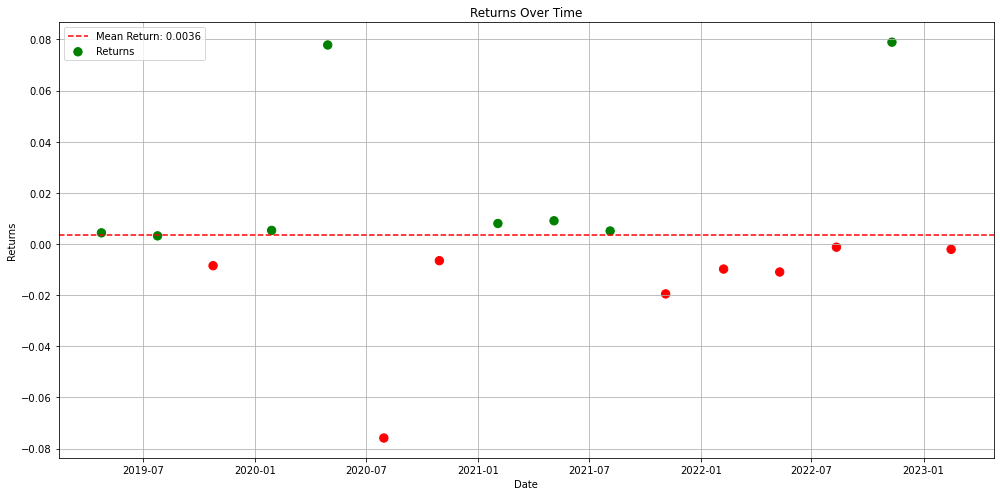

In [15]:
import matplotlib.pyplot as plt

# Calculate the mean return
mean_return = results_df['Returns'].mean()

# Define colors based on return values
colors = ['green' if ret > 0 else 'red' for ret in results_df['Returns']]

# Plotting the returns as scatter plot with color based on return value
plt.figure(figsize=(14, 7))
plt.scatter(results_df.index, results_df['Returns'], label='Returns', color=colors, s=70)  # Adjust size (s) as needed
plt.axhline(y=mean_return, color='red', linestyle='--', label=f"Mean Return: {mean_return:.4f}")
plt.title('Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()


# Save the figure
plt.savefig("Model 2 Returns Over Time.png", dpi=300)  # Adjust dpi for quality

plt.show()


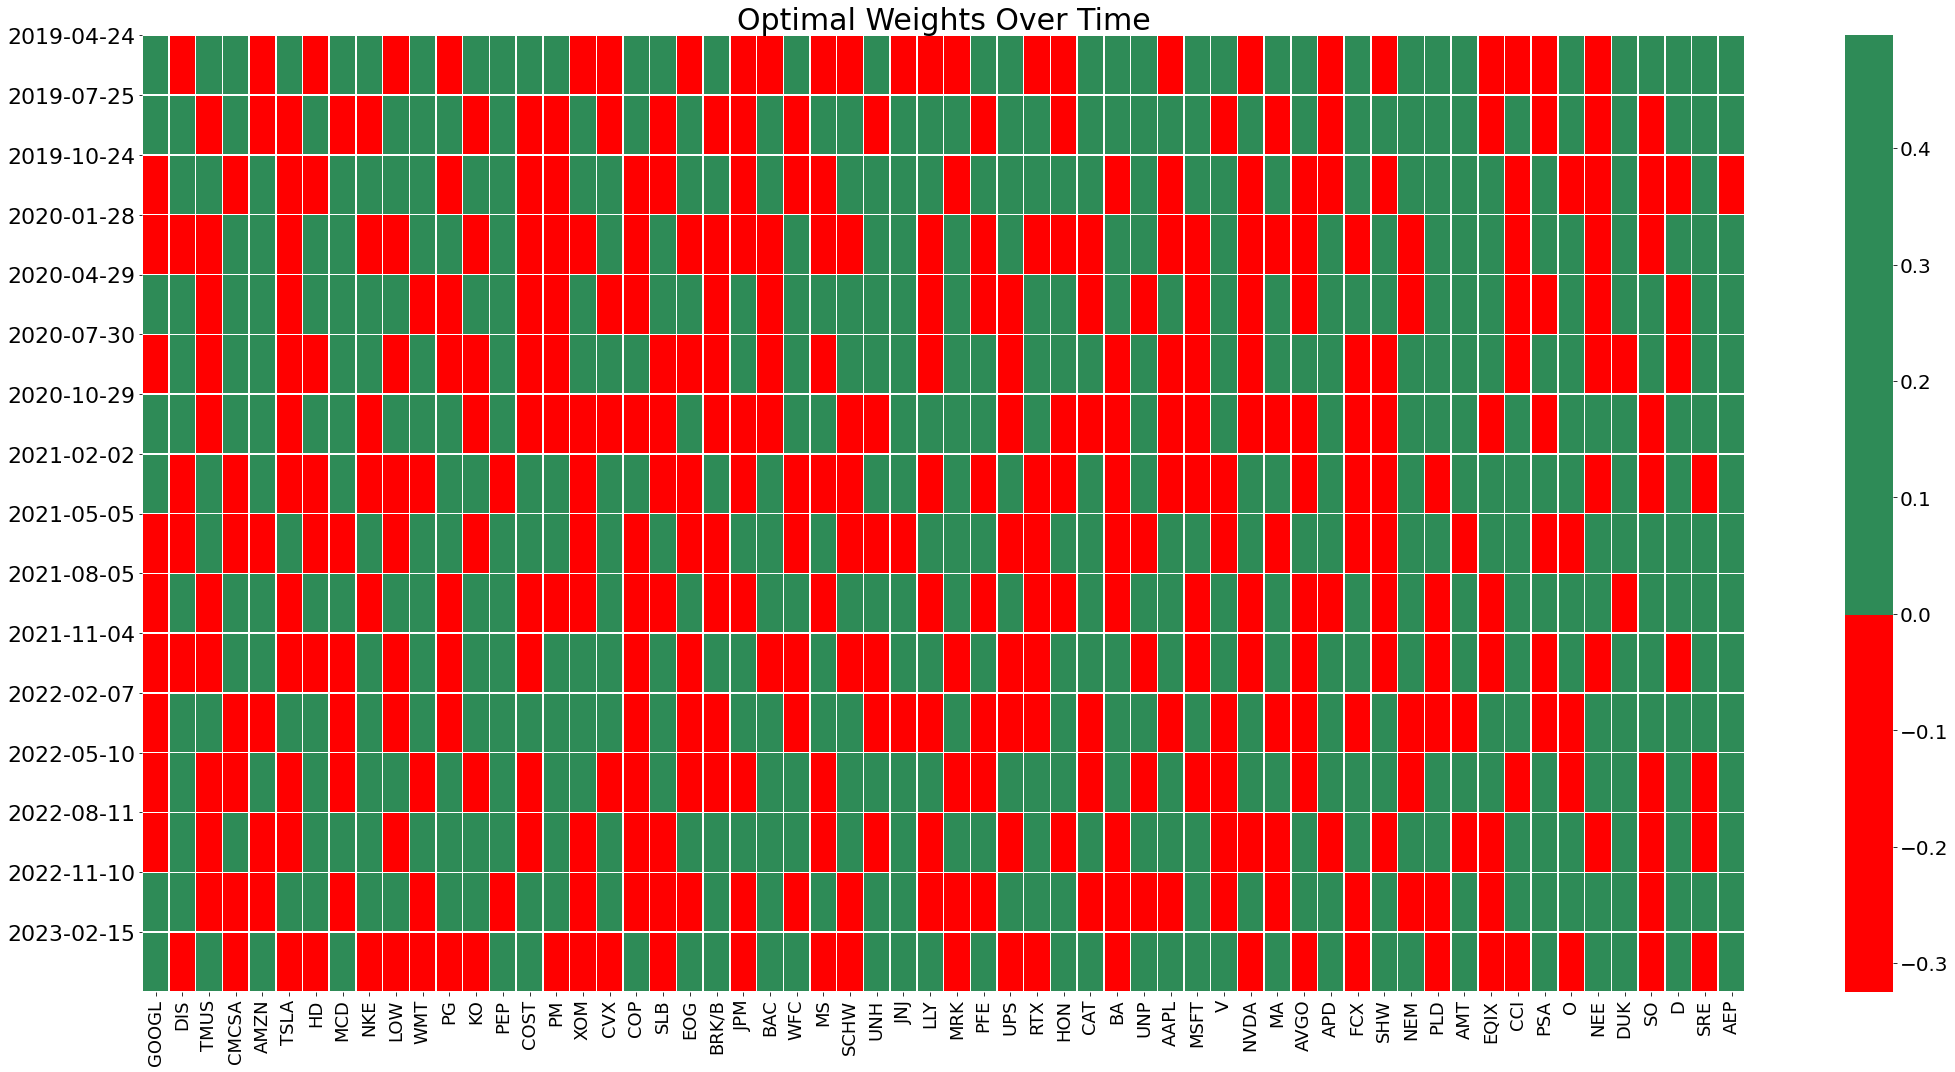

In [16]:
import seaborn as sns

# Reshape weights to 2D
weights_2d = np.array(weights).reshape(len(dates), -1)

# Convert reshaped weights to a DataFrame for easier plotting
weights_df = pd.DataFrame(weights_2d, index=dates, columns=stocks_data.columns)

# Remove "PX_LAST" suffix from stock names in the DataFrame
weights_df.columns = [col.replace('_PX_LAST', '') for col in weights_df.columns]

# Define a custom colormap with red for negative values and green for positive values
colors = ['red', 'seagreen']

cmap = sns.color_palette(colors, as_cmap=True)

# Plotting the heatmap
plt.figure(figsize=(30, 15))
heatmap = sns.heatmap(weights_df, cmap=cmap, cbar=True, linewidths=0.5, center=0)
plt.title('Optimal Weights Over Time', fontsize=30)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(ticks=np.arange(len(weights_df.index)), labels=weights_df.index.strftime('%Y-%m-%d'), fontsize=22)

# Access the color bar object and adjust the font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()

# Save the figure
plt.savefig("Model 2 Optimal Weights.png", dpi=300)  # Adjust dpi for quality
plt.show()

In [5]:
# Count the number of times each company has been assigned a negative weight
negative_counts = (weights_df < 0).sum()

# Sort the counts in descending order
top_negative_counts = negative_counts.sort_values(ascending=False)

# Get the top 10 companies with the most negative weights
top_10_negative_companies = top_negative_counts.head(10)

print("Top 10 companies with the most negative weights:")
print(top_10_negative_companies)

Top 10 companies with the most negative weights:
TSLA     12
COP      11
TMUS     10
AVGO     10
LLY      10
JPM      10
NVDA     10
COST     10
GOOGL     9
XOM       9
dtype: int64


In [6]:
# Extract the index (company names) of the top negative companies
top_negative_company_names = top_10_negative_companies.index

# Append suffix to each company name
formatted_company_names_negative = [name + "_ROBECOSAM_TOTAL_STBLY_RANK" for name in top_negative_company_names]

print("Formatted company names:")
print(formatted_company_names_negative)


Formatted company names:
['TSLA_ROBECOSAM_TOTAL_STBLY_RANK', 'COP_ROBECOSAM_TOTAL_STBLY_RANK', 'TMUS_ROBECOSAM_TOTAL_STBLY_RANK', 'AVGO_ROBECOSAM_TOTAL_STBLY_RANK', 'LLY_ROBECOSAM_TOTAL_STBLY_RANK', 'JPM_ROBECOSAM_TOTAL_STBLY_RANK', 'NVDA_ROBECOSAM_TOTAL_STBLY_RANK', 'COST_ROBECOSAM_TOTAL_STBLY_RANK', 'GOOGL_ROBECOSAM_TOTAL_STBLY_RANK', 'XOM_ROBECOSAM_TOTAL_STBLY_RANK']


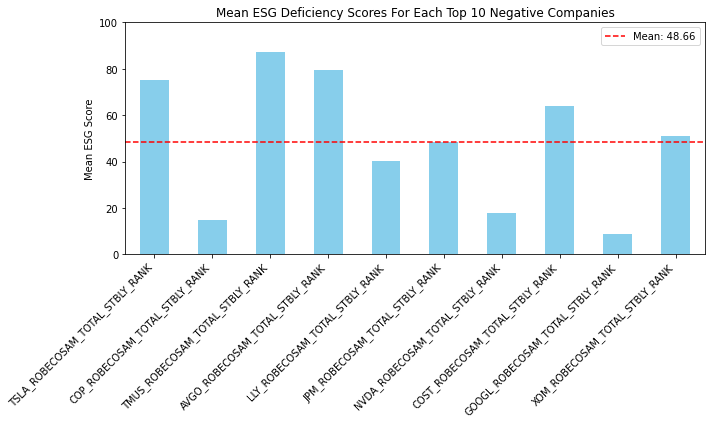

In [13]:
# Filter the ESG data based on the trading dates
esg_scores_trades = ESG_data.loc[dates_traded]

# Calculate the mean of the ESG scores for the specified formatted company names
mean_scores_neg = esg_scores_trades[formatted_company_names_negative].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
mean_scores_neg.plot(kind='bar', color='skyblue')
plt.title('Mean ESG Deficiency Scores For Each Top 10 Negative Companies')

plt.ylabel('Mean ESG Score')
plt.xticks(rotation=45, ha='right')

# Set y-axis limits
plt.ylim(0, 100)

# Add a red horizontal line for the mean
mean_value = mean_scores_neg.mean()
plt.axhline(y=mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig("Model 2 Mean ESG Score Top 10 Neg.png", dpi=300)  # Adjust dpi for quality
plt.show()


In [8]:
# Count the number of times each company has been assigned a positive weight
positive_counts = (weights_df > 0).sum()

# Sort the counts in descending order
top_positive_counts = positive_counts.sort_values(ascending=False)

# Get the top 10 companies with the most positive weights
top_10_positive_companies = top_positive_counts.head(10)

print("Top 10 companies with the most positive weights:")
print(top_10_positive_companies)

Top 10 companies with the most positive weights:
AEP    15
DUK    14
PEP    14
JNJ    13
AMT    13
SRE    12
D      12
WMT    11
UNP    11
NEM    11
dtype: int64


In [9]:
# Extract the index (company names) of the top positive companies
top_positive_company_names = top_10_positive_companies.index

# Append suffix to each company name
formatted_company_names_positive = [name + "_ROBECOSAM_TOTAL_STBLY_RANK" for name in top_positive_company_names]

# Print the formatted company names for positive weights
print("Formatted company names for positive weights:")
print(formatted_company_names_positive)

Formatted company names for positive weights:
['AEP_ROBECOSAM_TOTAL_STBLY_RANK', 'DUK_ROBECOSAM_TOTAL_STBLY_RANK', 'PEP_ROBECOSAM_TOTAL_STBLY_RANK', 'JNJ_ROBECOSAM_TOTAL_STBLY_RANK', 'AMT_ROBECOSAM_TOTAL_STBLY_RANK', 'SRE_ROBECOSAM_TOTAL_STBLY_RANK', 'D_ROBECOSAM_TOTAL_STBLY_RANK', 'WMT_ROBECOSAM_TOTAL_STBLY_RANK', 'UNP_ROBECOSAM_TOTAL_STBLY_RANK', 'NEM_ROBECOSAM_TOTAL_STBLY_RANK']


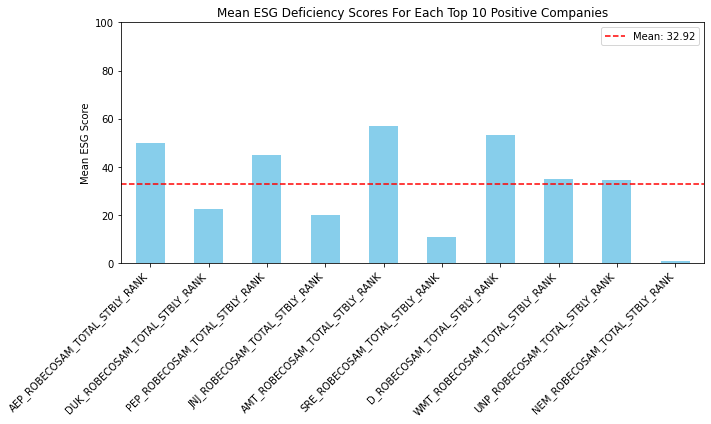

In [14]:
# Filter the ESG data based on the trading dates
esg_scores_trades = ESG_data.loc[dates_traded]

# Calculate the mean of the ESG scores for the specified formatted company names
mean_scores_pos = esg_scores_trades[formatted_company_names_positive].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
mean_scores_pos.plot(kind='bar', color='skyblue')
plt.title('Mean ESG Deficiency Scores For Each Top 10 Positive Companies')
plt.ylabel('Mean ESG Score')
plt.xticks(rotation=45, ha='right')

# Set y-axis limits
plt.ylim(0, 100)

# Calculate and add a red horizontal line for the mean
mean_value_pos = mean_scores_pos.mean()
plt.axhline(y=mean_value_pos, color='red', linestyle='--', label=f'Mean: {mean_value_pos:.2f}')
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig("Model 2 Mean ESG Score Top 10 Pos.png", dpi=300)  # Adjust dpi for quality
plt.show()